In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape, GaussianNoise, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
data_dir = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"

In [3]:
def load_images_to_numpy(src_path: str) -> np.ndarray:
    res = os.listdir(src_path)
    res = map(lambda path: os.path.join(src_path, path), res)
    res = map(Image.open, res)
    res = map(np.asarray, res)
    res = np.stack([*res], axis=0)
    return res

def load_images(src_path: str):
    X_false = load_images_to_numpy(os.path.join(src_path, "NORMAL"))
    y_false = np.zeros((X_false.shape[0],), dtype=np.uint8)

    X_true = load_images_to_numpy(os.path.join(src_path, "PNEUMONIA"))
    y_true = np.ones((X_true.shape[0],), dtype=np.uint8)

    X = np.concatenate([X_false, X_true])
    y = np.concatenate([y_false, y_true])
    return (X, y)

In [4]:
X, y = load_images(os.path.join(data_dir, "train"))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [6]:
def make_model(shape, activation, **kwargs):
    model = Sequential()

    model.add(InputLayer(shape))
    model.add(Reshape((shape[0], shape[1], 1)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(1, activation=activation))

    model.compile(**kwargs)
    return model

In [15]:
model = make_model(
  shape=(X_train.shape[1], X_train.shape[2]),
  activation='sigmoid',
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 280, 400, 1)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 278, 398, 64)      640       
                                                                 
 conv2d_27 (Conv2D)          (None, 276, 396, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 138, 198, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 136, 196, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 134, 194, 128)     147584    
                                                      

In [17]:
model_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/vgg16"
if not os.path.isdir(model_path):
        os.makedirs(model_path)

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[
        ModelCheckpoint(
          filepath=os.path.join(model_path, "model.h5"),
          save_best_only=True,
          monitor='val_loss',
          mode='min'
        )
    ]
)

Epoch 1/100
132/132 [==============================] - 43s 278ms/step - loss: 21.5679 - accuracy: 0.7081 - val_loss: 0.5936 - val_accuracy: 0.7489
Epoch 2/100
132/132 [==============================] - 75s 568ms/step - loss: 0.5823 - accuracy: 0.7422 - val_loss: 0.5637 - val_accuracy: 0.7489
Epoch 3/100
132/132 [==============================] - 32s 243ms/step - loss: 0.5729 - accuracy: 0.7422 - val_loss: 0.5643 - val_accuracy: 0.7489
Epoch 4/100
132/132 [==============================] - 32s 242ms/step - loss: 0.5724 - accuracy: 0.7422 - val_loss: 0.5638 - val_accuracy: 0.7489
Epoch 5/100
132/132 [==============================] - 50s 377ms/step - loss: 0.5713 - accuracy: 0.7422 - val_loss: 0.5636 - val_accuracy: 0.7489
Epoch 6/100
132/132 [==============================] - 32s 241ms/step - loss: 0.5715 - accuracy: 0.7422 - val_loss: 0.5650 - val_accuracy: 0.7489
Epoch 7/100
132/132 [==============================] - 62s 474ms/step - loss: 0.5715 - accuracy: 0.7422 - val_loss: 0.5635 

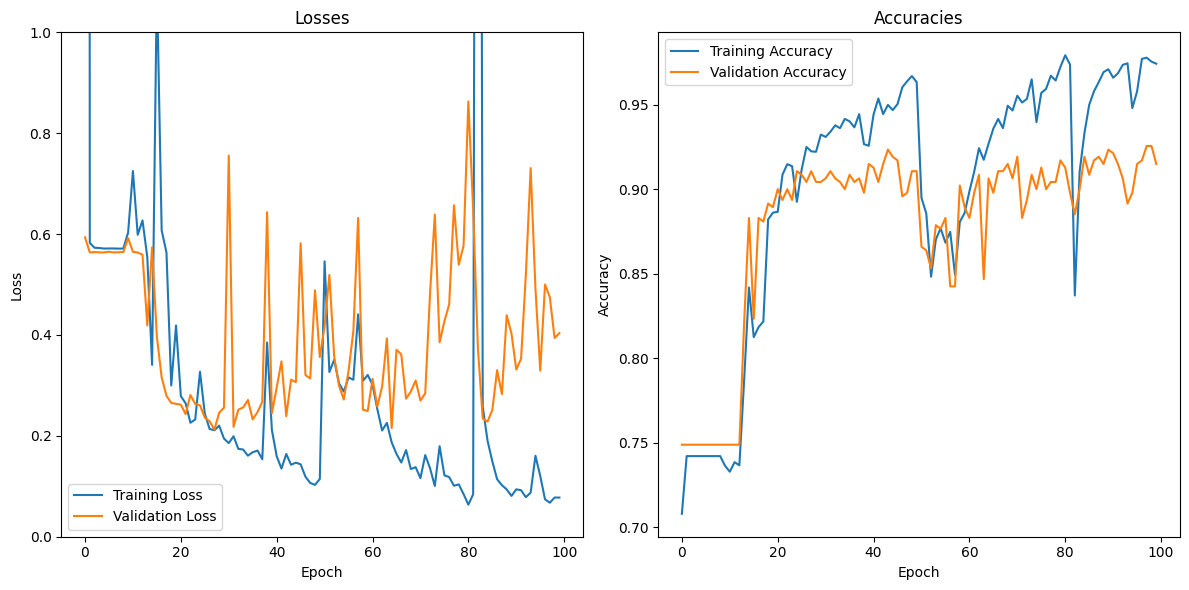

In [19]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

Bez detaljne analize da se videti da bi ovaj model morao jos mnogo da se trenira da bi bio blizu u performansama drugim modelima. S obzirom na razliku u veličini, sa delićem broja parametara možemo brže postići bolje performanse.

To nije problem arhitekture modela već samog problema koji rešavamo: jednostavniji je i ima manje stvari da se vodi računa.